# VGGFace 2 and Lime Full Pipeline

We need to do five things:
1. Crop faces with MTCNN
2. Extract features with VGGFace2
3. Run Classifier
4. Fit all in one pipeline
5. Run Lime

In [117]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Crop Face

In [119]:
img_path = "./sample_images/sam_beard.jpg"
face_path = "./sample_images/sam_beard_crop.jpg"

In [120]:
from crop_face import crop_faces, convert_face_tensor_to_numpy_array

face = crop_faces(img_path, keep_all=False)

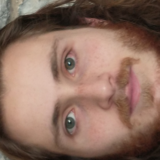

In [121]:
image = Image.fromarray(convert_face_tensor_to_numpy_array(face))
display(image)

In [136]:
image.rotate(-90).save(face_path)

## Load VGGFace2

In [123]:
from saved_model.prepare_resnet50 import prepare_resnet_model

resnet_model = prepare_resnet_model("./saved_model/resnet50_ft_weight.pkl")

## Load Pretrained Binary Classifier Neural Network

In [124]:
from saved_model.binary_classifier import load_pretrained_classifier

binary_classifier = load_pretrained_classifier('./saved_model/weights-2.pth')

## Putting it all together

In [137]:
from data.load_image import load_image_for_feature_extraction

img, original = load_image_for_feature_extraction(face_path, shape=(224,224,3))

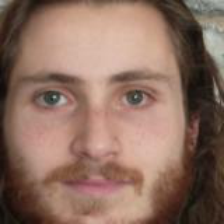

In [138]:
display(original)

In [139]:
def full_pipeline(x):
    x = torch.Tensor(x.transpose(0, 3, 1, 2))  # 1x3x224x224
    x = x.to(device)
    x = resnet_model(x)
    x = torch.sigmoid(binary_classifier(x))
    return x.detach().cpu().numpy()

In [140]:
label_dict = {0: "liberal", 1: "conservative"}

def predict_face(img_arr):
    img_arr = np.expand_dims(img_arr, 0) # 1x224x224x3
    prediction = full_pipeline(img_arr).squeeze(0)
    pred_int = np.rint(prediction) # 0 or 1
    label = [label_dict[i] for i in pred_int]
    confidence = 1 - prediction if pred_int == 0 else prediction
    
    return prediction, label, confidence

In [141]:
prediction, label, confidence = predict_face(img)
print(f'Predicted class: {label[0]}, with confidence: {confidence[0]} (Original score: {prediction[0]})')

Predicted class: conservative, with confidence: 0.5686627626419067 (Original score: 0.5686627626419067)


# Lime

In [142]:
from lime import lime_image

In [143]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, full_pipeline, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [144]:
from skimage.segmentation import mark_boundaries

In [145]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)

In [146]:
img_boundry = mark_boundaries(temp/255.0, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


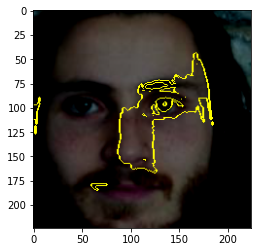

In [147]:
plt.imshow(img_boundry)